# Classification on Imbalanced Data

This example shows classification done using imbalanced data. The dataset is from Kaggle:

> The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

> It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

[Source](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)

## Binary Cross Entropy Loss Function

$$L = -\dfrac{1}{m} \sum_{i=1}^{m} \left( y_i log \left(\hat{y}_i \right) + \left(1 - y_i\right) log \left(1 - \hat{y}_i \right) \right)$$

, where $y_i$ is the actual value of the i:th training sample, $\hat{y}_i$ is the predicted value for the i:th value and $m$ is the number of samples. Since the loss function is a sum over all of the samples, if we have very unbalanced dataset, misclassifications cause a very small increase in the overall loss. This can be remedied, up to certain degree, by weighting the loss, for each $i$, depending on how the data is imbalanced. Also when training the network it might be necessary to make sure that the training samples actually contain samples for each of the classes.

This work is on-going as the results are still not good!

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Reduce TF verbosity
import tensorflow as tf
from tensorflow import keras
tf.get_logger().setLevel('INFO') # Reduce TF verbosity
print(f"tensorflow version: {tf.__version__}")

import opendatasets as od
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score

import matplotlib.pyplot as plt
import utils

tensorflow version: 2.11.0


In [2]:
print(f"GPU is available: {tf.config.list_physical_devices('GPU')}")

GPU is available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Read the data into a data-frame
od.download("https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?resource=download")
data_frame = pd.read_csv("./creditcardfraud/creditcard.csv")
data_frame.head()

Skipping, found downloaded files in "./creditcardfraud" (use force=True to force download)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# Show column names
data_frame.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [5]:
# Show unique values for class
print(f'Unique values in the Class-column: {np.unique(data_frame["Class"].to_numpy())}')

Unique values in the Class-column: [0 1]


In [6]:
# Show number of samples per class
data_frame.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

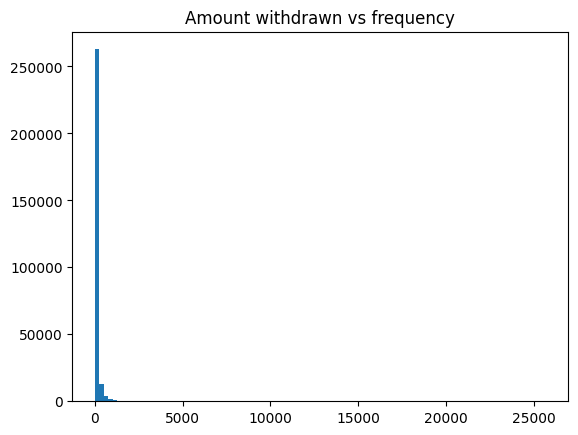

In [7]:
# Show distribution of the amount of money withdrawn
plt.hist(data_frame['Amount'], bins=100)
plt.title('Amount withdrawn vs frequency')
plt.show()

In [8]:
# Since the amount of withdrawn varies a lot, we take a logarithm of it
data_frame_clean = data_frame.copy()
data_frame_clean.pop('Time')
data_frame_clean.pop('Amount')
data_frame_clean['Log amount'] = np.log(data_frame['Amount'] + np.finfo('float').eps)
data_frame_clean.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Log amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,5.008099
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,0.989541
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,5.936639
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,4.816241
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,4.248352


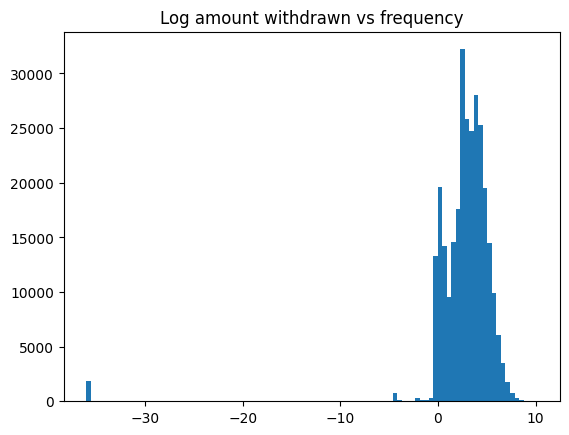

In [9]:
# Show distribution of the amount of money withdrawn
plt.hist(data_frame_clean['Log amount'], bins=100)
plt.title('Log amount withdrawn vs frequency')
plt.show()

In [10]:
neg, pos = np.bincount(data_frame['Class'])
total = neg + pos
print(f'Negative samples: {neg} ({neg/total*100}%)')
print(f'Positive samples: {pos} ({pos/total*100}%)')
print(f'Total samples: {total}')

Negative samples: 284315 (99.82725143693798%)
Positive samples: 492 (0.1727485630620034%)
Total samples: 284807


In [11]:
# Split the dataset into training, valuation and testing datasets
train_df, test_df = sklearn.model_selection.train_test_split(data_frame_clean, train_size=0.8)
train_df, val_df = sklearn.model_selection.train_test_split(train_df, train_size=0.8)

# Extract labels
train_label = train_df.pop('Class').to_numpy()
test_label = test_df.pop('Class').to_numpy()
val_label = val_df.pop('Class').to_numpy()

# Extract features
train_features = train_df.copy().to_numpy()
test_features = test_df.copy().to_numpy()
val_features = val_df.copy().to_numpy()

print(f'Train features shape: {train_features.shape}')
print(f'Test features shape: {test_features.shape}')
print(f'Val features shape: {val_features.shape}')
print('---------')
print(f'Train label shape: {train_label.shape}')
print(f'Test label shape: {test_label.shape}')
print(f'Val label shape: {val_label.shape}')

Train features shape: (182276, 29)
Test features shape: (56962, 29)
Val features shape: (45569, 29)
---------
Train label shape: (182276,)
Test label shape: (56962,)
Val label shape: (45569,)


In [12]:
# Scale features. Scaling parameters are based on the train_features
scaler = sklearn.preprocessing.StandardScaler()
train_features = scaler.fit_transform(train_features)

train_features = scaler.transform(train_features)
test_features = scaler.transform(test_features)
val_features = scaler.transform(val_features)

# Clip the values to be between -5 to 5
#train_features = train_features.clip(-5, 5)
#test_features = test_features.clip(-5, 5)
#val_features = val_features.clip(-5, 5)

In [13]:
# Show mean and std of the train features
print(f'Mean of train_features:\n{train_features.mean(axis=0).round(2)}')
print(f'Std of train features:\n{train_features.std(axis=0).round(2)}')

Mean of train_features:
[-0.   -0.    0.   -0.    0.   -0.    0.    0.    0.    0.   -0.   -0.
 -0.   -0.   -0.   -0.    0.    0.    0.    0.   -0.    0.    0.   -0.
  0.   -0.   -0.   -0.   -0.75]
Std of train features:
[0.51 0.61 0.66 0.71 0.74 0.76 0.82 0.83 0.91 0.92 0.98 1.   1.01 1.04
 1.09 1.14 1.17 1.19 1.23 1.3  1.35 1.37 1.56 1.65 1.92 2.07 2.52 3.09
 0.27]


## Model

In [14]:
# Create a model using TF2 functional API
def make_model():
    inputs = keras.Input(shape=(29,))
    x = keras.layers.Dense(16, activation='relu', kernel_initializer='HeNormal')(inputs)
    x = keras.layers.Dropout(0.5)(x)
    outputs = keras.layers.Dense(1, activation='sigmoid', kernel_initializer='HeNormal')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [15]:
BATCH_SIZE = 100
EPOCHS = 50

# TensorFlow curiosity. If we use the data 'as is', i.e. without the batch-operator, then we have to reshape
# the data so that the batch-size is 1
#train = tf.data.Dataset.from_tensor_slices((train_features.reshape(-1, 1, 29), train_label.reshape(-1, 1, 1)))

train = tf.data.Dataset.from_tensor_slices((train_features, train_label)).batch(BATCH_SIZE)
validation = tf.data.Dataset.from_tensor_slices((val_features, val_label)).batch(BATCH_SIZE)
test = tf.data.Dataset.from_tensor_slices((test_features, test_label)).batch(BATCH_SIZE)

# Without Class Weights

We already know that the dataset is highly imbalanced as we very few positive examples of fraud. Therefore, we expect that a model that has been trained without taking this into account will not yield a particularly good model.

In [16]:
# Create a model
original_model = make_model()
original_model.summary()

# We use Adam (adaptive moments) optimizer and binary cross entropy loss function
original_model.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

# Fit the model
non_weighted_hist = original_model.fit(
    train,
    validation_data = validation,
    epochs = EPOCHS
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 29)]              0         
                                                                 
 dense (Dense)               (None, 16)                480       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1823/1823 [==============================] - 10s 4ms/step - loss: 0.1053 - accuracy: 0.9697 - val_loss: 0.0136 - val_accuracy: 0.9993
Epoch 2/50
1823/1823 [============================

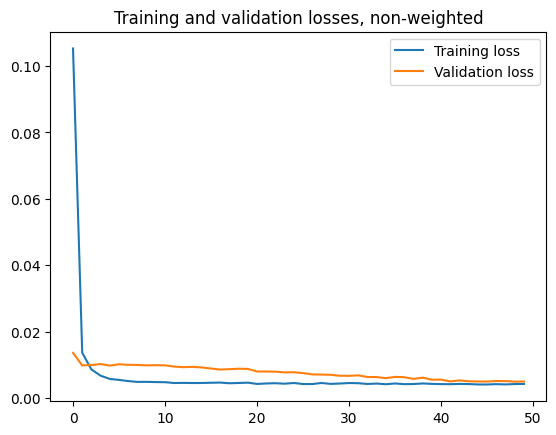

In [17]:
# Plot training- and cross-validation losses
plt.plot(non_weighted_hist.history['loss'], label='Training loss')
plt.plot(non_weighted_hist.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('Training and validation losses, non-weighted')
ax = plt.plot()

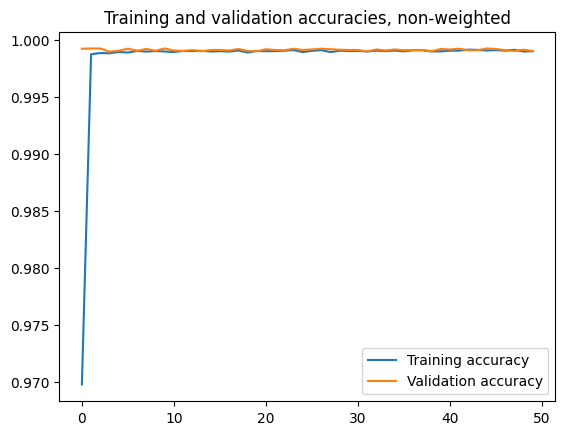

In [18]:
# Plot training- and cross-validation accuracy
plt.plot(non_weighted_hist.history['accuracy'], label='Training accuracy')
plt.plot(non_weighted_hist.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracies, non-weighted')
plt.legend()
ax = plt.plot()

1781/1781 [==============================] - 2s 1ms/step


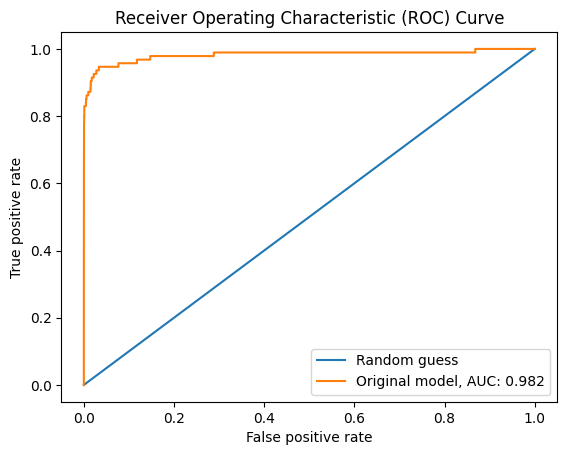

In [19]:
# Infer predictions
test_predictions_org = original_model.predict(test_features)

# Show Receiver Operating Characteristic (ROC) curve
fpr_org, tpr_org, thresholds_org = roc_curve(test_label, test_predictions_org)
auc_score_org = roc_auc_score(test_label, test_predictions_org)

plt.plot([0, 1], [0, 1], label='Random guess')
plt.plot(fpr_org, tpr_org, label=f'Original model, AUC: {auc_score_org:.3f}')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

[0.         0.0106383  0.20212766 ... 1.         1.         1.        ]


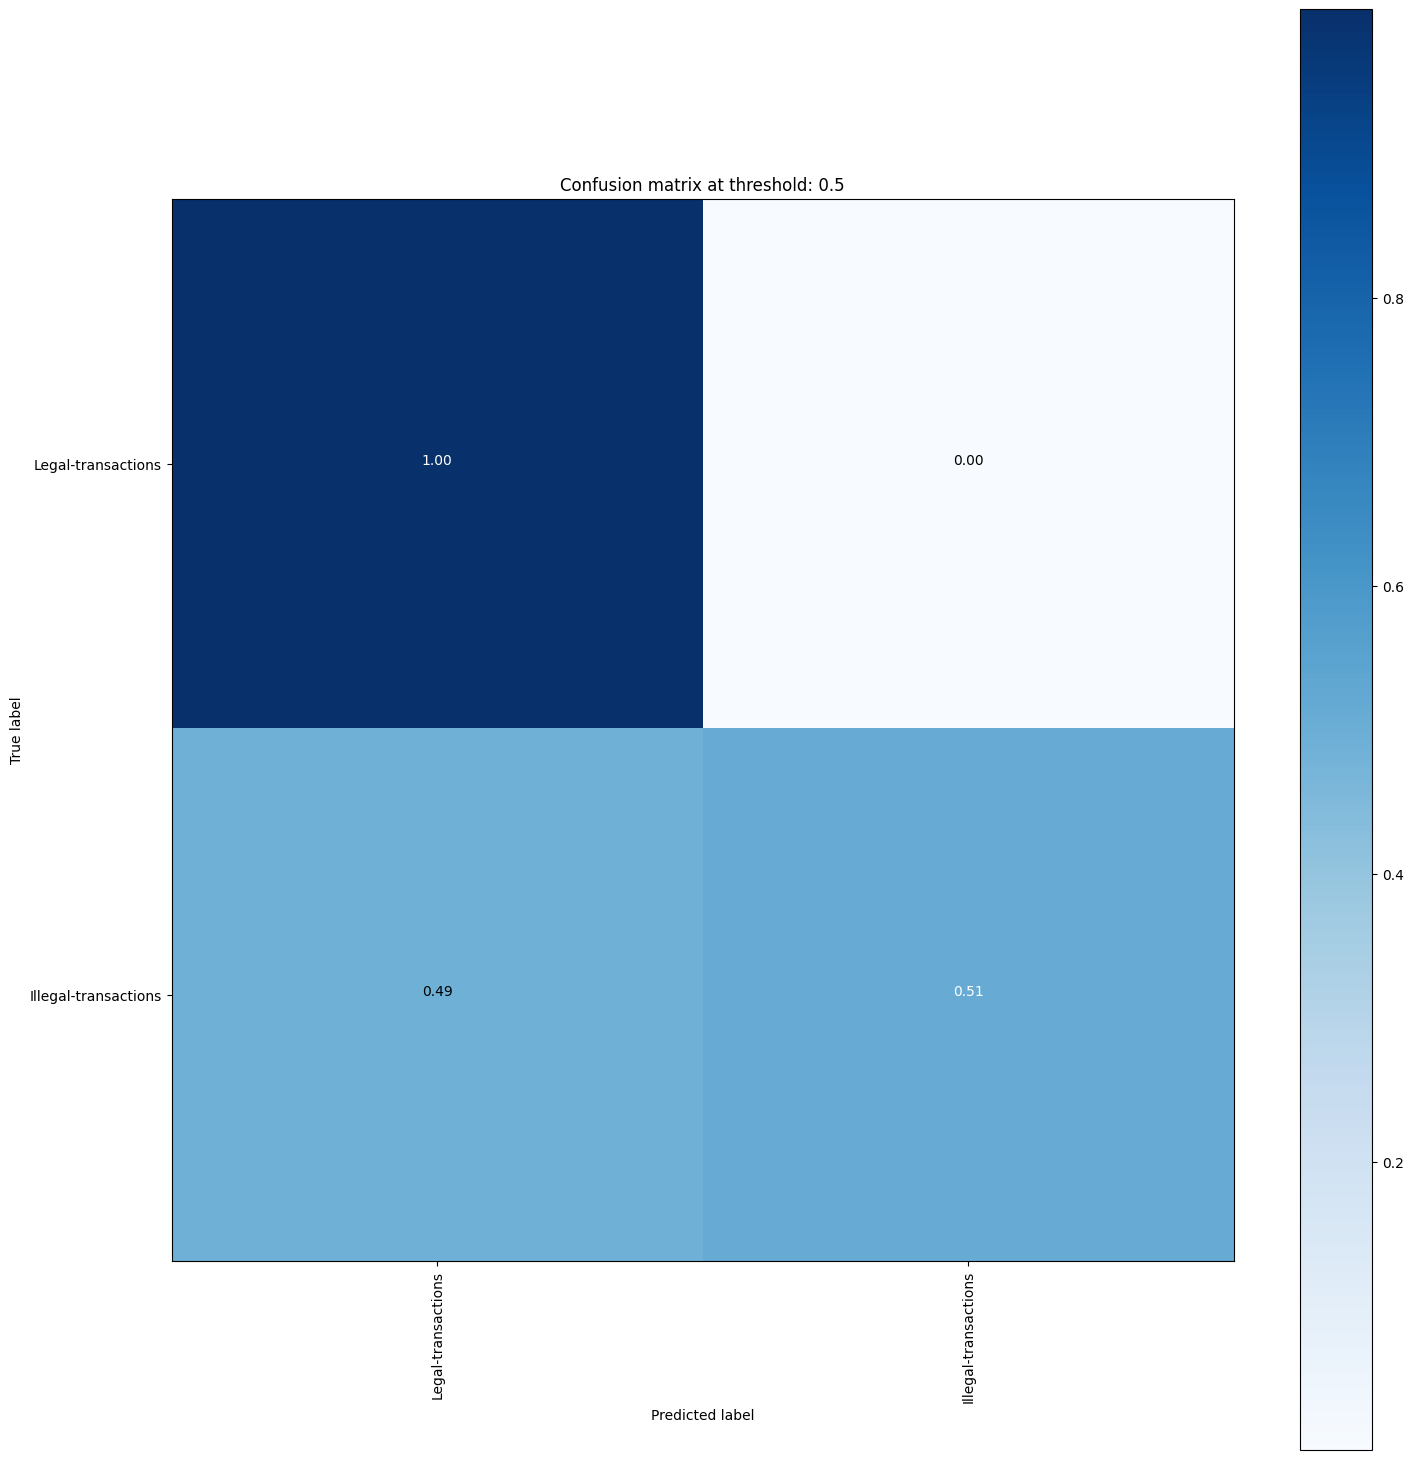

In [27]:
# Show confusion matrix at threshold = 0.5
labels = '''Legal-transactions
            Illegal-transactions'''.split()
cm = confusion_matrix(test_label, test_predictions_org >= 0.5)
utils.plot_confusion_matrix(cm, labels, normalize=True, title='Confusion matrix at threshold: 0.5')

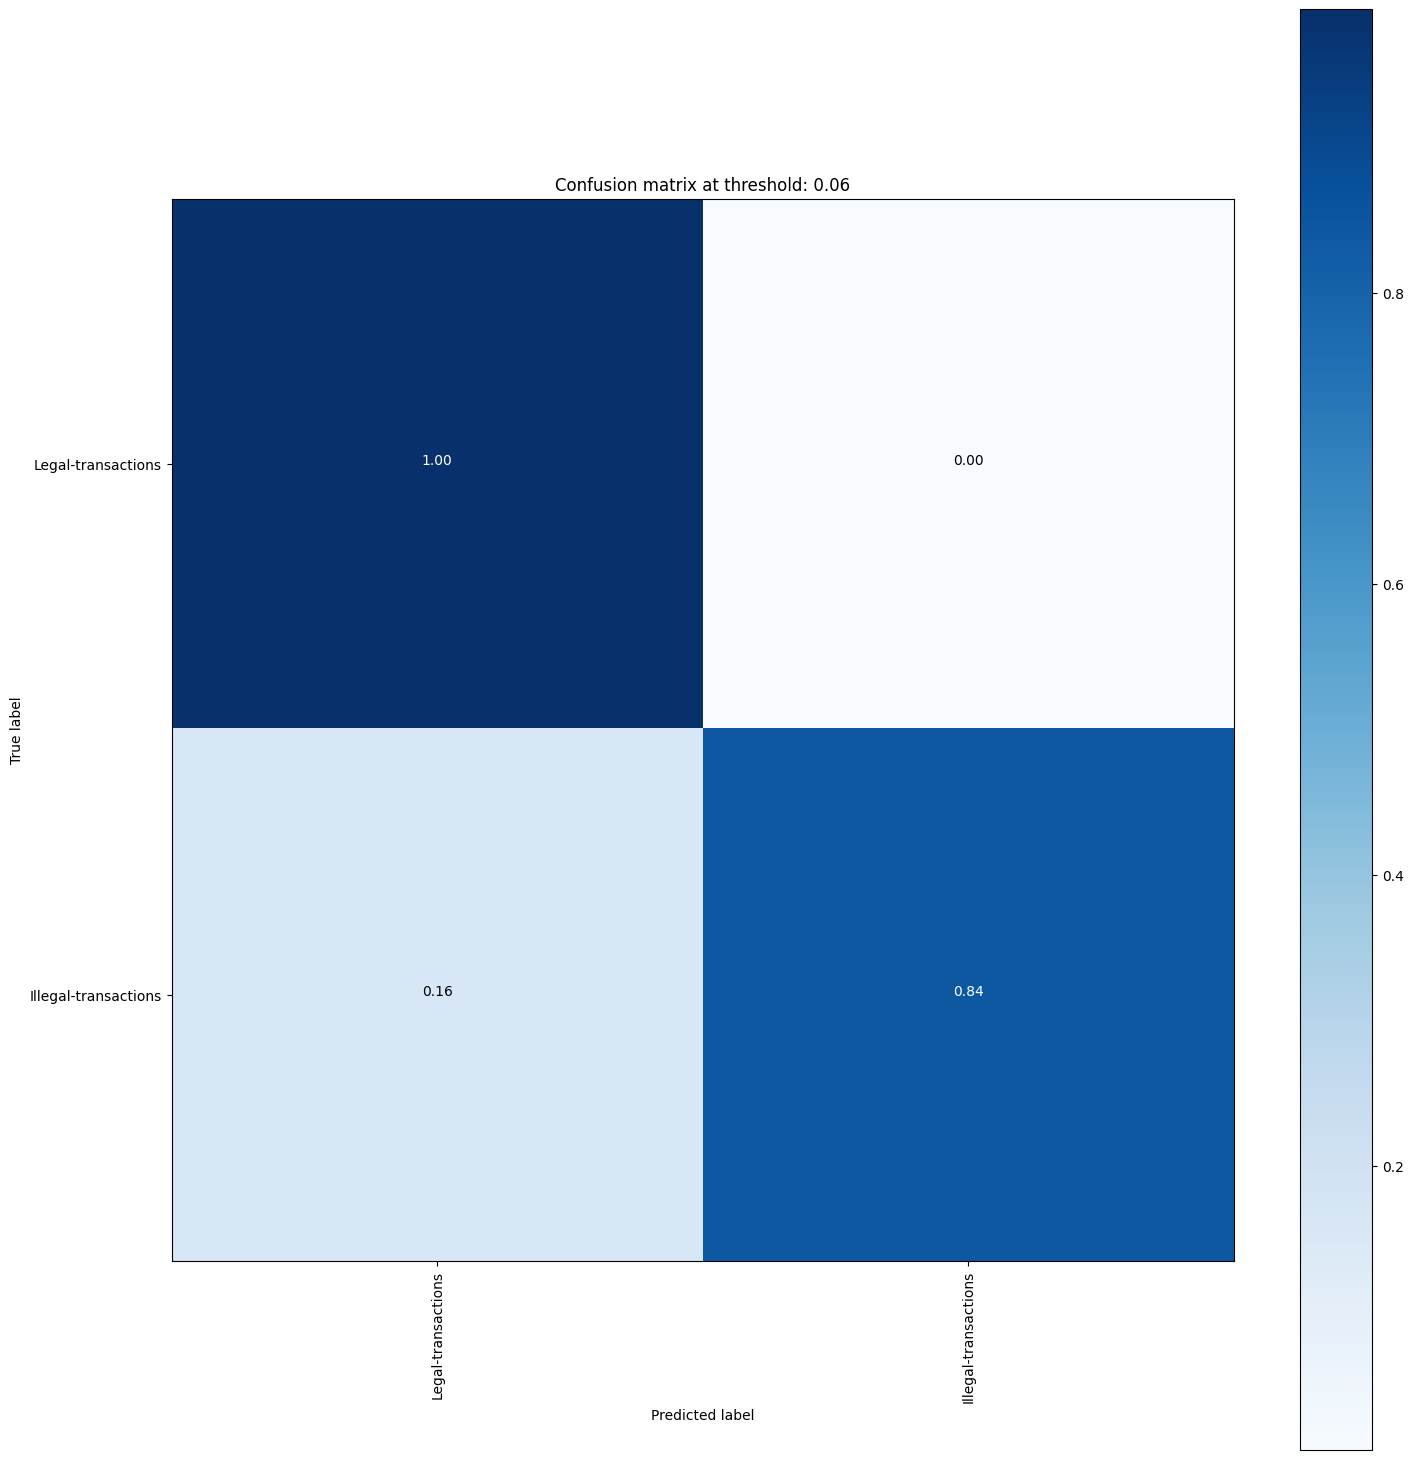

In [42]:
cm = confusion_matrix(test_label, test_predictions_org >= 0.06)
utils.plot_confusion_matrix(cm, labels, normalize=True, title='Confusion matrix at threshold: 0.06')

# With Class Weights

In [21]:
# These are the weights given for each class in order to balance the loss function
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

print(f'Weight for 0: {weight_for_0}')
print(f'Weight for 1: {weight_for_1}')

Weight for 0: 0.5008652375006595
Weight for 1: 289.43800813008136


In [22]:
# Create a model
weighted_model = make_model()
weighted_model.summary()


weighted_model.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

weighted_hist = weighted_model.fit(
    train,
    validation_data = validation,
    epochs = EPOCHS,
    class_weight = class_weight
    
)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 29)]              0         
                                                                 
 dense_2 (Dense)             (None, 16)                480       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1823/1823 [==============================] - 9s 4ms/step - loss: 0.7631 - accuracy: 0.7812 - val_loss: 0.3108 - val_accuracy: 0.9620
Epoch 2/50
1823/1823 [===========================

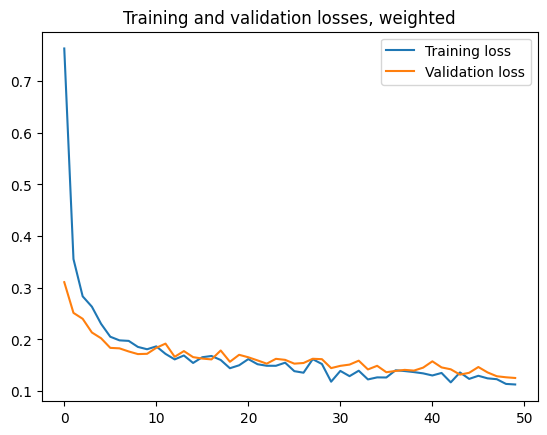

In [23]:
# Plot training- and cross-validation losses
plt.plot(weighted_hist.history['loss'], label='Training loss')
plt.plot(weighted_hist.history['val_loss'], label='Validation loss')
plt.title('Training and validation losses, weighted')
plt.legend()
ax = plt.plot()

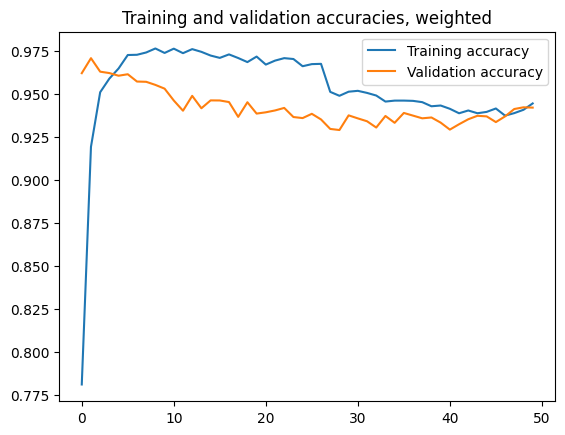

In [24]:
# Plot training- and cross-validation accuracy
plt.plot(weighted_hist.history['accuracy'], label='Training accuracy')
plt.plot(weighted_hist.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracies, weighted')
plt.legend()
ax = plt.plot()

1781/1781 [==============================] - 2s 1ms/step


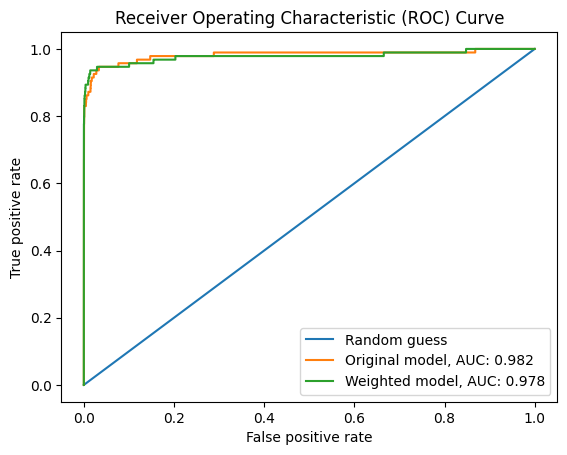

In [25]:
# Infer predictions for the test values and draw a confusion matrix
test_predictions_weighted = weighted_model.predict(test_features)

# Show Receiver Operating Characteristic (ROC) curve
fpr_weighted, tpr_weighted, thresholds_weighted = roc_curve(test_label, test_predictions_weighted)
auc_score_weighted = roc_auc_score(test_label, test_predictions_weighted)

plt.plot([0, 1], [0, 1], label='Random guess')
plt.plot(fpr_org, tpr_org, label=f'Original model, AUC: {auc_score_org:.3f}')
plt.plot(fpr_weighted, tpr_weighted, label=f'Weighted model, AUC: {auc_score_weighted:.3f}')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

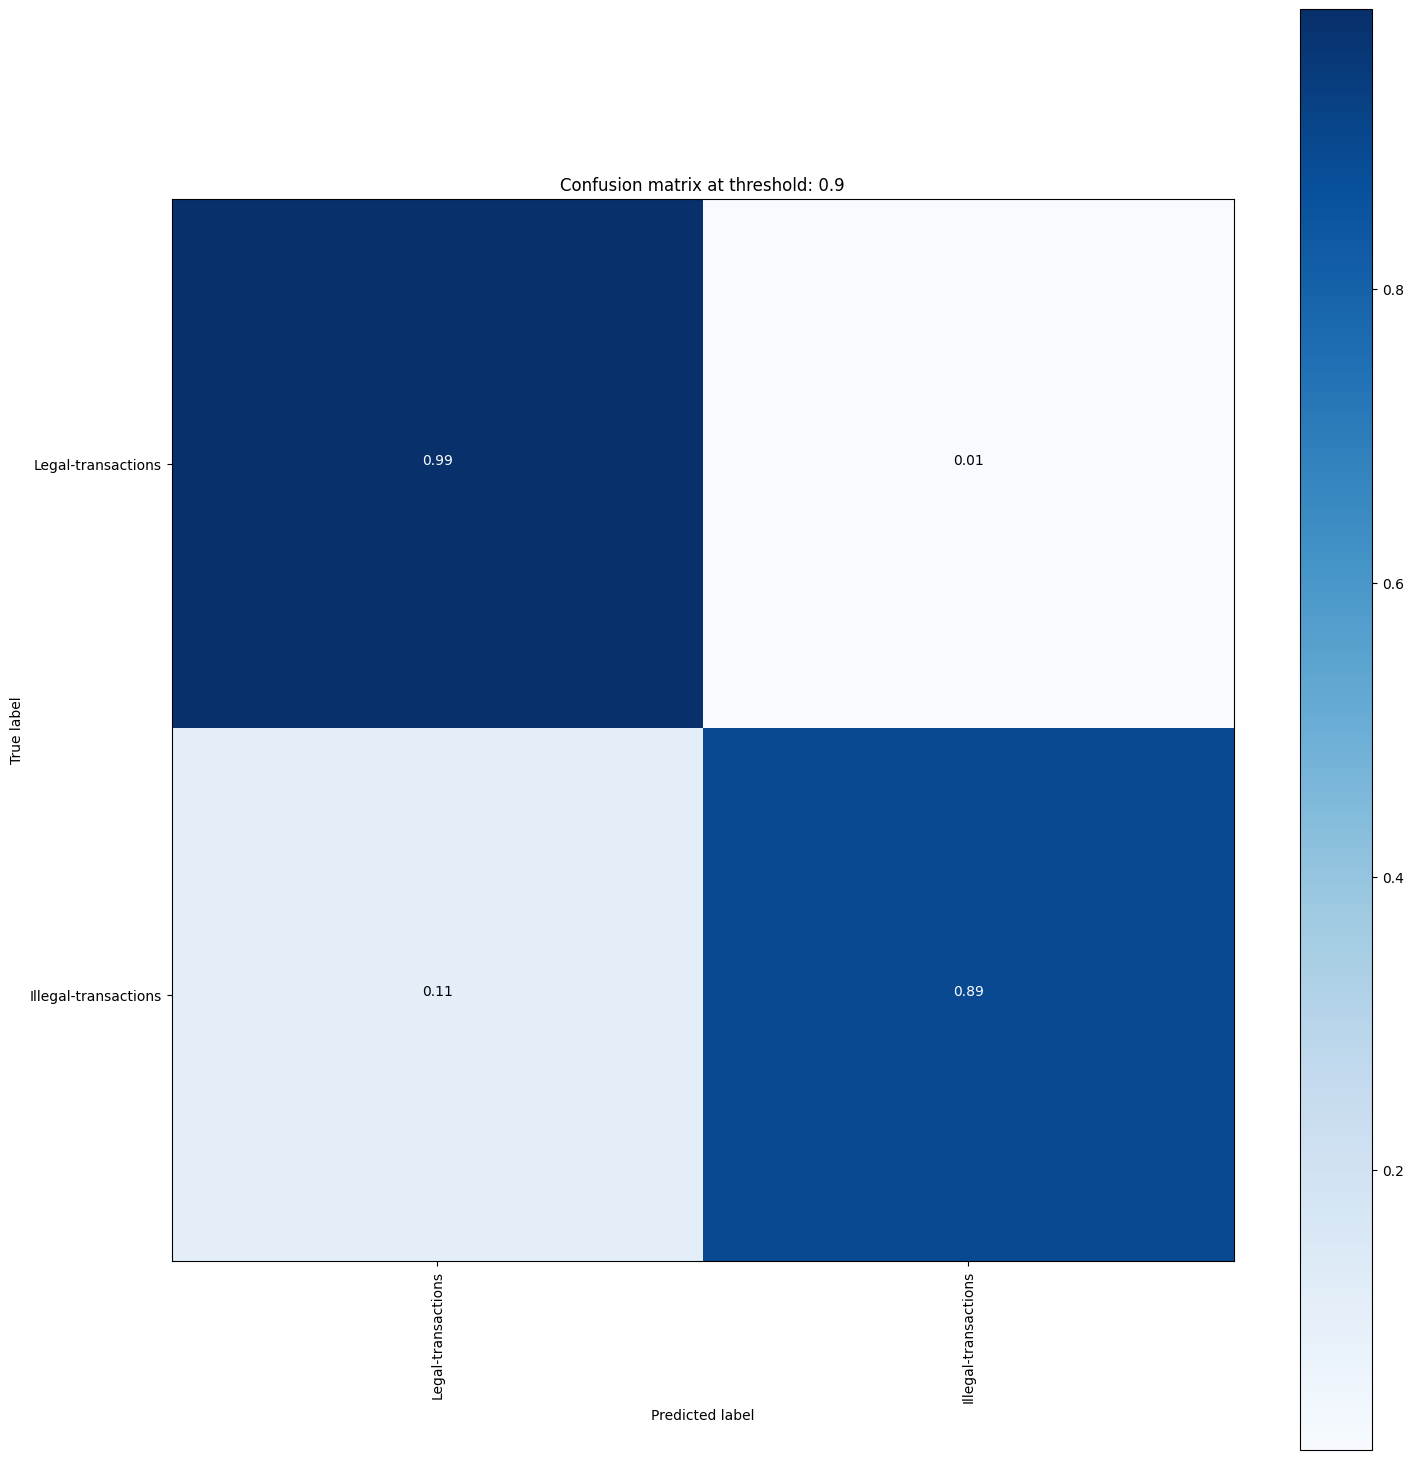

In [48]:
# Show confusion matrix
labels = '''Legal-transactions
            Illegal-transactions'''.split()
cm = confusion_matrix(test_label, test_predictions_weighted >= 0.9)
utils.plot_confusion_matrix(cm, labels, normalize=True, title='Confusion matrix at threshold: 0.9')